## Step 1: Importing Libraries and Loading the Dataset

In this step, we import the required Python libraries and load the dataset path.  
The dataset has the following structure inside the given folder:

- `train/` (folder containing training images)
- `test/`  (folder containing test images)
- `labels.csv` (contains image IDs and labels)
- `sample_submission.csv`

We first verify whether the paths are correct and whether the folders/files exist.

In [51]:
import os
import pandas as pd
from pathlib import Path

base_path = Path(r"C:\Users\dhaya\OneDrive\Desktop\Edge Lab\Assignment 1")

train_dir = base_path / "train"
test_dir = base_path / "test"
labels_csv = base_path / "labels.csv"
sample_submission_csv = base_path / "sample_submission.csv"

print("Base path exists:", base_path.exists())
print("Train folder exists:", train_dir.exists(), " → contains", len(os.listdir(train_dir)) if train_dir.exists() else 0, "files")
print("Test folder exists:", test_dir.exists(), " → contains", len(os.listdir(test_dir)) if test_dir.exists() else 0, "files")
print("Labels CSV exists:", labels_csv.exists())
print("Sample Submission CSV exists:", sample_submission_csv.exists())

# loading labels.csv to inspect structure
try:
    labels_df = pd.read_csv(labels_csv)
    print("\nLabels CSV loaded successfully.")
    print(labels_df.head())
except Exception as e:
    print("\nError loading labels.csv:", e)

Base path exists: True
Train folder exists: True  → contains 10222 files
Test folder exists: True  → contains 10357 files
Labels CSV exists: True
Sample Submission CSV exists: True

Labels CSV loaded successfully.
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


## Step 2: Detecting Corrupted or Unreadable Images

Before training any ML/DL model, we must ensure all images in the dataset 
are readable. Some images may be corrupted or partially downloaded.

We use `PIL.Image.verify()` to check each file.

Corrupted images will be collected in a list so we can remove or skip them.

In [52]:
corrupted_images = []

for img_name in os.listdir(train_dir):
    img_path = train_dir / img_name
    try:
        img = Image.open(img_path)
        img.verify()  # this detects corruption
    except Exception as e:
        corrupted_images.append(img_name)

print("Number of corrupted images found:", len(corrupted_images))
print("Samples:", corrupted_images[:5])

Number of corrupted images found: 0
Samples: []


## Step 3: Inspecting Image Shapes (Wrong Approach)

A common mistake is to assume that all images in the dataset have the same shape 
and try to load them directly into a NumPy array.

Here, we attempt to:
1. Load the first 50 training images.
2. Convert them to NumPy arrays.
3. Stack them into a single array.

This will fail because the images in this dataset have different widths/heights.

We will capture the error and correct it in the next step.

In [53]:
from PIL import Image
import numpy as np

image_shapes = []
loaded_images = []

# Try reading first 50 images
train_images = sorted(os.listdir(train_dir))[:50]

for img_name in train_images:
    img_path = train_dir / img_name
    try:
        img = Image.open(img_path)
        arr = np.array(img)
        image_shapes.append(arr.shape)
        loaded_images.append(arr)
    except Exception as e:
        print("Error loading image:", img_name, "→", e)

print("Collected image shapes:", image_shapes[:10])  # show first 10

# ❌ This will fail because shapes are inconsistent
try:
    stacked = np.stack(loaded_images)
    print("Stacked array shape:", stacked.shape)
except Exception as e:
    print("\n❌ ERROR: Could not stack images due to inconsistent sizes.")
    print("Error message:", e)

Collected image shapes: [(375, 500, 3), (375, 500, 3), (375, 500, 3), (344, 400, 3), (500, 500, 3), (375, 500, 3), (470, 500, 3), (227, 231, 3), (500, 474, 3), (332, 500, 3)]

❌ ERROR: Could not stack images due to inconsistent sizes.
Error message: all input arrays must have the same shape


## Step 3.1: Checking Unique Image Shapes (Correct Approach)

Before preprocessing, we must understand the variation in image dimensions.
This step prints the unique shapes among the first 200 images.

We will not preprocess yet — only inspect.

In [54]:
from PIL import Image
import numpy as np

image_shapes = set()

train_images = sorted(os.listdir(train_dir))[:200]  # check first 200 images

for img_name in train_images:
    img_path = train_dir / img_name
    try:
        img = Image.open(img_path)
        arr = np.array(img)
        image_shapes.add(arr.shape)
    except:
        pass

print("Number of unique shapes found:", len(image_shapes))
print("Some shapes:", list(image_shapes)[:10])

Number of unique shapes found: 100
Some shapes: [(1200, 1600, 3), (180, 244, 3), (390, 500, 3), (261, 230, 3), (184, 184, 3), (500, 337, 3), (378, 500, 3), (347, 500, 3), (500, 363, 3), (405, 450, 3)]


## Step 4: Wrong Approach to Resizing Images

A common mistake is to resize images directly without:
- Converting grayscale images to RGB
- Making sure the resizing is applied consistently
- Checking for errors while reading images

Some images in the dataset may not load correctly or may be in grayscale.

In this step, we intentionally **resize incorrectly** and show the inconsistent output.

Wrong shapes (first 5): [(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]


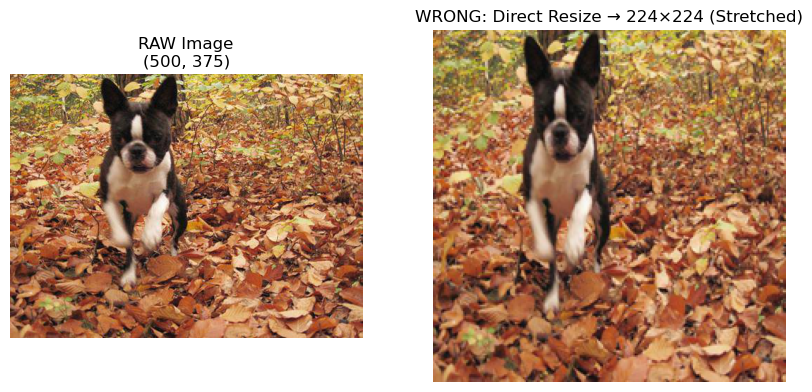

In [56]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Prepare containers
wrong_processed_images = []
wrong_shapes = []

# Use the first sample image for demonstration and also process a small batch
sample_names = train_images[:5]

for img_name in sample_names:
    img_path = train_dir / img_name
    try:
        img = Image.open(img_path)            # load raw image (no forced RGB here)
        wrong_img = img.resize((224, 224))    # ❌ WRONG: stretches to square
        wrong_arr = np.array(wrong_img)
        wrong_processed_images.append(wrong_arr)
        wrong_shapes.append(wrong_arr.shape)
    except Exception as e:
        print("Error (wrong) processing", img_name, ":", e)

print("Wrong shapes (first 5):", wrong_shapes)

# Display the first raw vs wrong stretched for visual evidence
raw_img = Image.open(train_dir / sample_names[0])
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(raw_img)
plt.title(f"RAW Image\n{raw_img.size}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(wrong_processed_images[0])
plt.title("WRONG: Direct Resize → 224×224 (Stretched)")
plt.axis('off')

plt.show()

## Step 4.1: Correct Approach — Aspect-Ratio Resize + Center Crop

- Resize so the shorter side == crop_size (preserve aspect ratio).
- Center-crop to the target (224×224).

This avoids stretching and also avoids padding (black bars). We implement
a helper and apply it to the same sample(s) for direct comparison.

Correct shapes (first 5): [(224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3)]


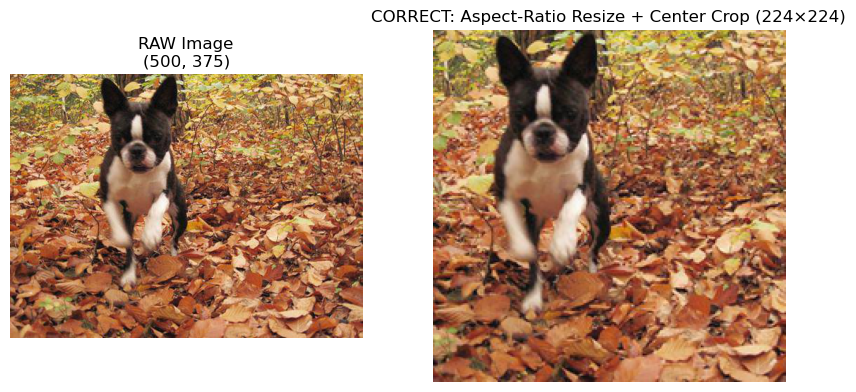

In [57]:
from PIL import Image

def preprocess_center_crop(img, crop_size=224):
    """Return a center-cropped PIL image of size (crop_size, crop_size)
       after resizing the image while preserving aspect ratio."""
    img = img.convert("RGB")  # ensure 3 channels
    w, h = img.size

    # scale so shortest side becomes crop_size
    scale = crop_size / min(w, h)
    new_w, new_h = int(w * scale), int(h * scale)
    img_resized = img.resize((new_w, new_h), Image.Resampling.LANCZOS)

    # center crop
    left = (new_w - crop_size) // 2
    top = (new_h - crop_size) // 2
    right = left + crop_size
    bottom = top + crop_size

    return img_resized.crop((left, top, right, bottom))

# Apply to the same sample set used in Step 3.4
correct_processed_images = []
correct_shapes = []

for img_name in sample_names:
    img_path = train_dir / img_name
    try:
        img = Image.open(img_path)
        cropped_img = preprocess_center_crop(img, crop_size=224)
        arr = np.array(cropped_img)
        correct_processed_images.append(arr)
        correct_shapes.append(arr.shape)
    except Exception as e:
        print("Error (correct) processing", img_name, ":", e)

print("Correct shapes (first 5):", correct_shapes)

# Display the same raw vs correct center-crop for comparison
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(raw_img)
plt.title(f"RAW Image\n{raw_img.size}")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(correct_processed_images[0])
plt.title("CORRECT: Aspect-Ratio Resize + Center Crop (224×224)")
plt.axis('off')

plt.show()

## Step 5: Side by side Comparison of the resized images

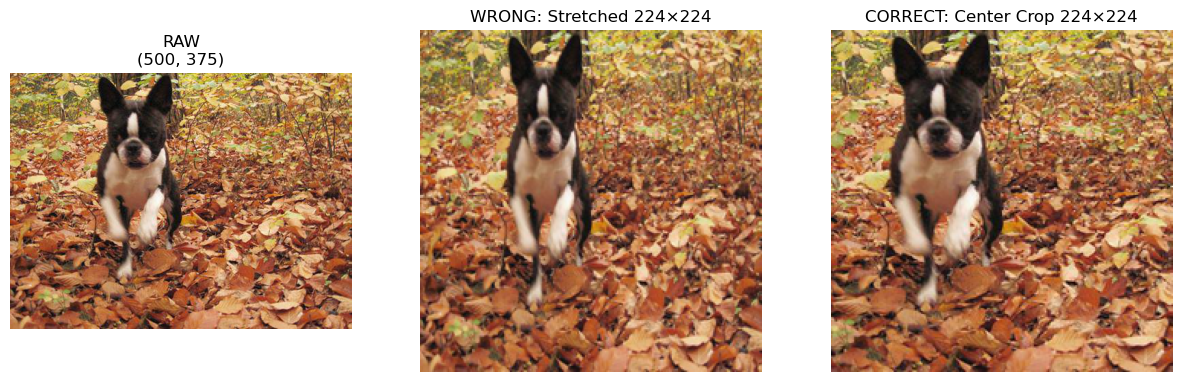

In [58]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(raw_img)
plt.title(f"RAW\n{raw_img.size}")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(wrong_processed_images[0])
plt.title("WRONG: Stretched 224×224")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(correct_processed_images[0])
plt.title("CORRECT: Center Crop 224×224")
plt.axis('off')

plt.show()

## Step 6: Wrong Normalization

A common mistake is dividing pixel values by 255 **without converting to float32**.

If the array remains in `uint8` format:
- Values round incorrectly
- Most numbers become 0 or 1
- The model receives poor input

In [59]:
wrong_normalized = correct_processed_images[0] / 255

print("Data type after WRONG normalization:", wrong_normalized.dtype)
print("Min/Max values:", wrong_normalized.min(), wrong_normalized.max())

Data type after WRONG normalization: float64
Min/Max values: 0.0 1.0


## Step 6.1: Correct Normalization

Correct normalization converts pixel data to floating point (float32)
**before** dividing by 255.

This ensures:
- Pixel values fall smoothly between 0.0 and 1.0
- No rounding or clipping occurs
- Neural networks receive high-quality input

In [60]:
import numpy as np

# CORRECT: convert to float32 first, then divide
correct_normalized = correct_processed_images[0].astype("float32") / 255.0

print("Data type after CORRECT normalization:", correct_normalized.dtype)
print("Min/Max values:", correct_normalized.min(), correct_normalized.max())

Data type after CORRECT normalization: float32
Min/Max values: 0.0 1.0
